In [1]:
import sys
import scanpy as sc 
import numpy as np

sys.path.append('/home/jupyter/data/PlastiNet_v2')

from plastinet.data.data_loader import create_data_objects
from plastinet.visualization.plots import plot_continous_obs, plot_tissue, plot_composition_dot_plot, plot_expression

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: 
object has no attribute sparse_csc_tensor:
  File "/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/torch_sparse/tensor.py", line 585
            value = torch.ones(self.nnz(), dtype=dtype, device=self.device())
    
        return torch.sparse_csc_tensor(colptr, row, value, self.sizes())
               ~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE

  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
adata = sc.read_h5ad("testing_data.h5ad") 

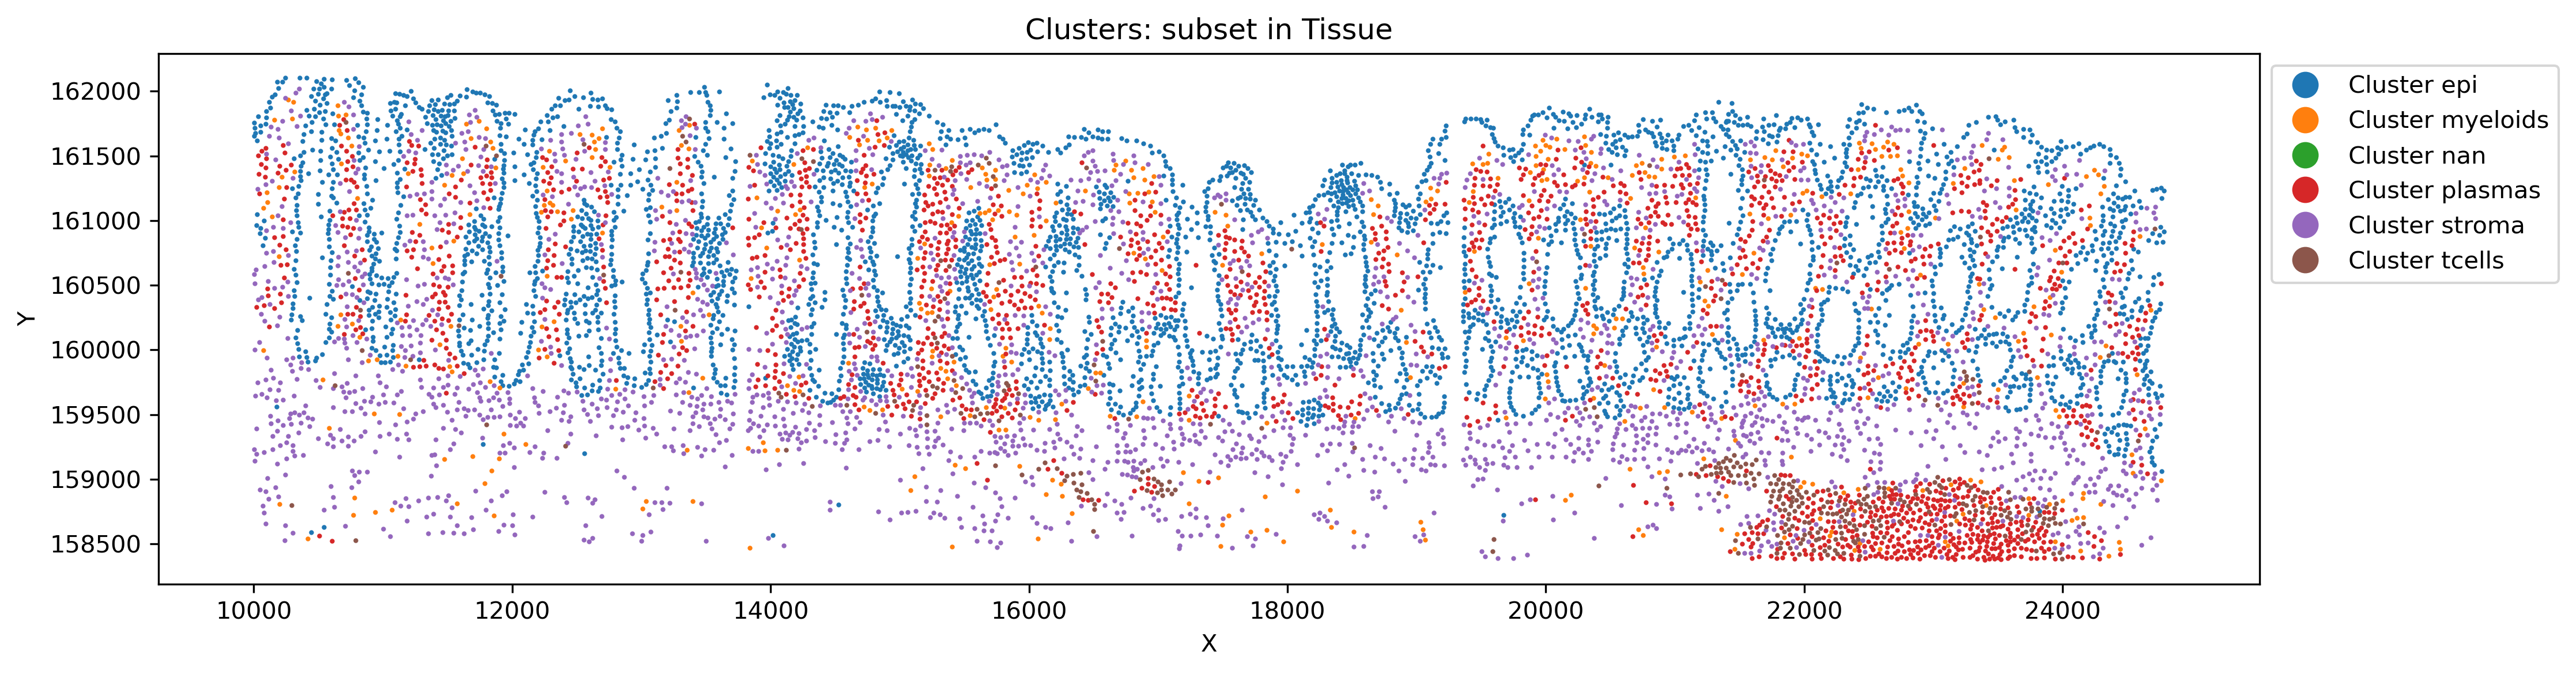

In [3]:
# plot spatialy by cell type 
plot_tissue(adata, "subset", figure_size=(15, 4))

In [4]:
# ensure spatial coordinates are in the correct place 
spatial_coords = np.array([adata.obs["X"], adata.obs["Y"]]).T
adata.obsm["spatial"] = spatial_coords

# Choose appropiate radius 

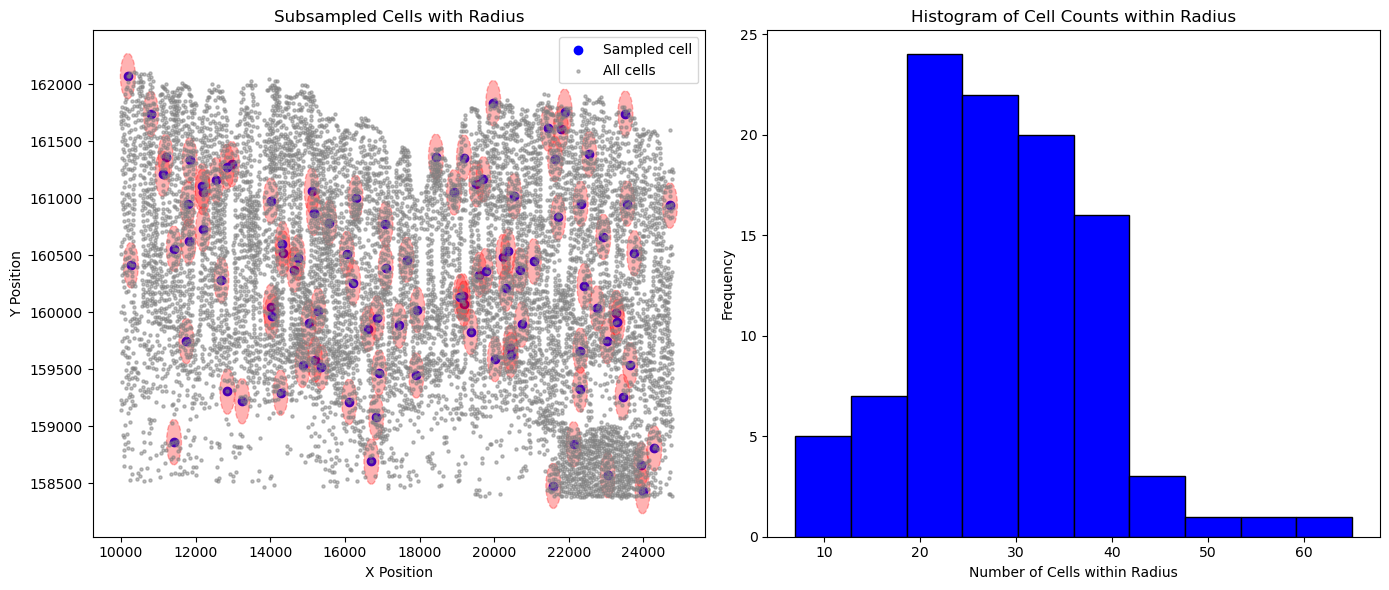

In [5]:
import plastinet.visualization.plots as plot
# select a radius that captures neighboring cells at desired resolution

plot.plot_subsample_radius(adata, x_samples = 100, radius = 200)

# Generate Embedding

Starting GAT run...
HC_b_
Model improved and parameters saved.
Epoch [1/150] Completed. Epoch Losses: DGI Loss = 1.3849, Spatial Loss = 0.5204, L1 Loss = 0.614298, Total Loss = 2.5196
Model improved and parameters saved.
Epoch [2/150] Completed. Epoch Losses: DGI Loss = 1.3749, Spatial Loss = 0.5008, L1 Loss = 0.579604, Total Loss = 2.4552
Model improved and parameters saved.
Epoch [3/150] Completed. Epoch Losses: DGI Loss = 1.3684, Spatial Loss = 0.4870, L1 Loss = 0.546012, Total Loss = 2.4014
Model improved and parameters saved.
Epoch [4/150] Completed. Epoch Losses: DGI Loss = 1.3621, Spatial Loss = 0.4852, L1 Loss = 0.514462, Total Loss = 2.3617
Model improved and parameters saved.
Epoch [5/150] Completed. Epoch Losses: DGI Loss = 1.3575, Spatial Loss = 0.4768, L1 Loss = 0.484387, Total Loss = 2.3187
Model improved and parameters saved.
Epoch [6/150] Completed. Epoch Losses: DGI Loss = 1.3535, Spatial Loss = 0.4661, L1 Loss = 0.455827, Total Loss = 2.2755
Model improved and paramet

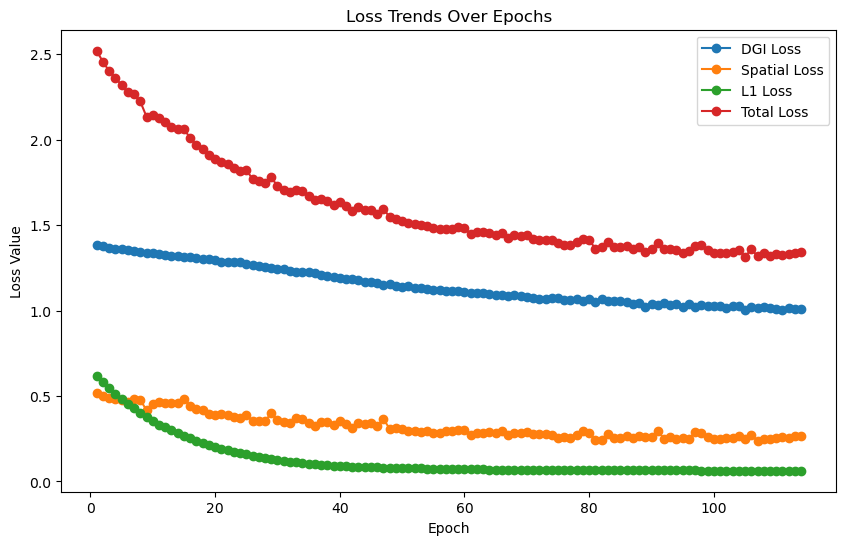

GAT run completed.


AnnData object with n_obs × n_vars = 9644 × 50
    obs: 'fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'sample_source', 'subset', 'fine_type', 'n_genes', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'X', 'Y'
    uns: 'neighbor_attention', 'reduction_layes'
    obsm: 'self_attention_weights_layer1', 'self_attention_weights_layer2'

In [5]:
import importlib
import torch
from torch_geometric.data import DataLoader

from plastinet.models import plastinet_model
from plastinet.data import data_loader, graph_utils
from plastinet.models.plastinet_model import PlastiNet
from plastinet.data.data_loader import create_data_objects
from plastinet.data.graph_utils import graph_alpha, sparse_mx_to_torch_edge_list, graph_to_sparse_matrix


plastinet = PlastiNet(
    adata=adata, # adata object
    sample_key= 'sample_source', # tissue source ID
    radius=200, # radius to consider        
    spatial_reg=2, # weighting of spatial term in loss function   
    z_dim=50,  # output feature size of embedding            
    lr=0.001,  # learning rate      
    beta_1=0.9, # self weighting in layer 1
    beta_2=0.1, # self weighting in layer 2
    alpha=5.0, # weight for stregth of distance decay 
    attention_threshold = 0.001,
    weight_decay=1e-5,  
    dropout=0.3,
    gamma=0.8, # decay in lr for each step_size incriment 
    epochs=150,
    random_seed=42,               
    patience=10,         
    mask_n = 0.7, # DGI percent of features to mask 
    spatial_percent = 0.2, # percent of cells to sample to calculate spatial loss 
    step_size = 10
)

plastinet.run_gat()

In [6]:
embedding_adata = plastinet.embedding_adata
embedding_adata

AnnData object with n_obs × n_vars = 9644 × 50
    obs: 'fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'sample_source', 'subset', 'fine_type', 'n_genes', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'X', 'Y'
    uns: 'neighbor_attention', 'reduction_layes'
    obsm: 'self_attention_weights_layer1', 'self_attention_weights_layer2'

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


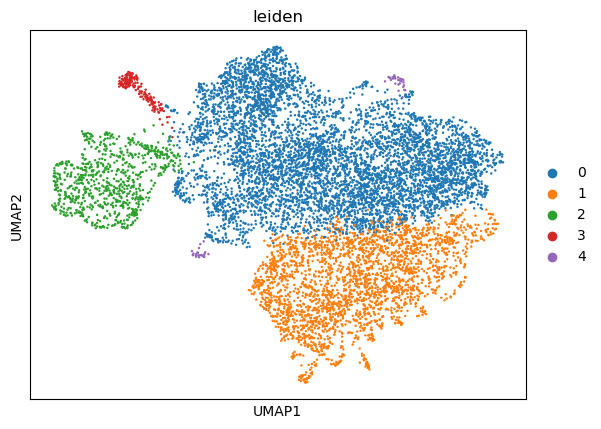

In [20]:
sc.pp.neighbors(embedding_adata, use_rep='X') 
sc.tl.umap(embedding_adata)
sc.tl.leiden(embedding_adata, resolution=0.1)
sc.pl.umap(embedding_adata, color = "leiden")

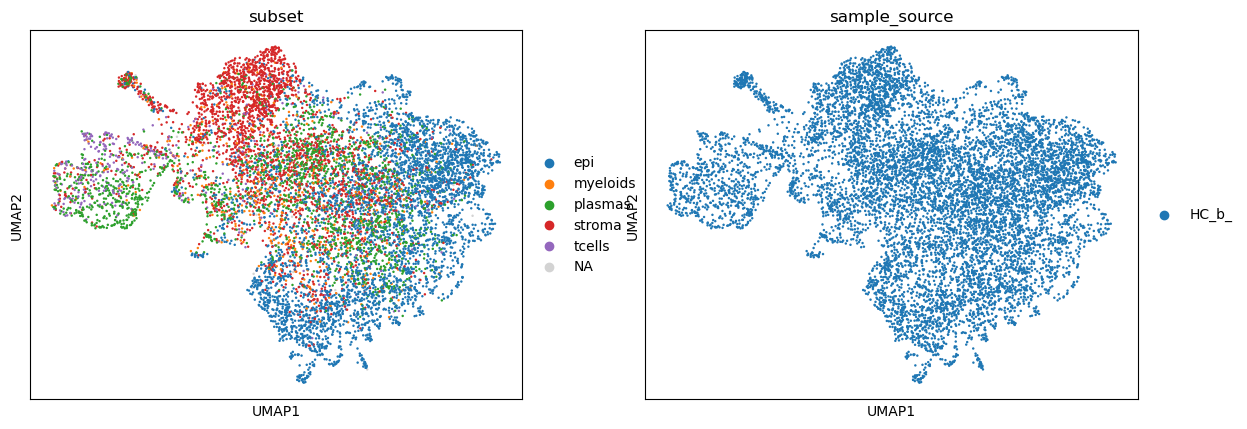

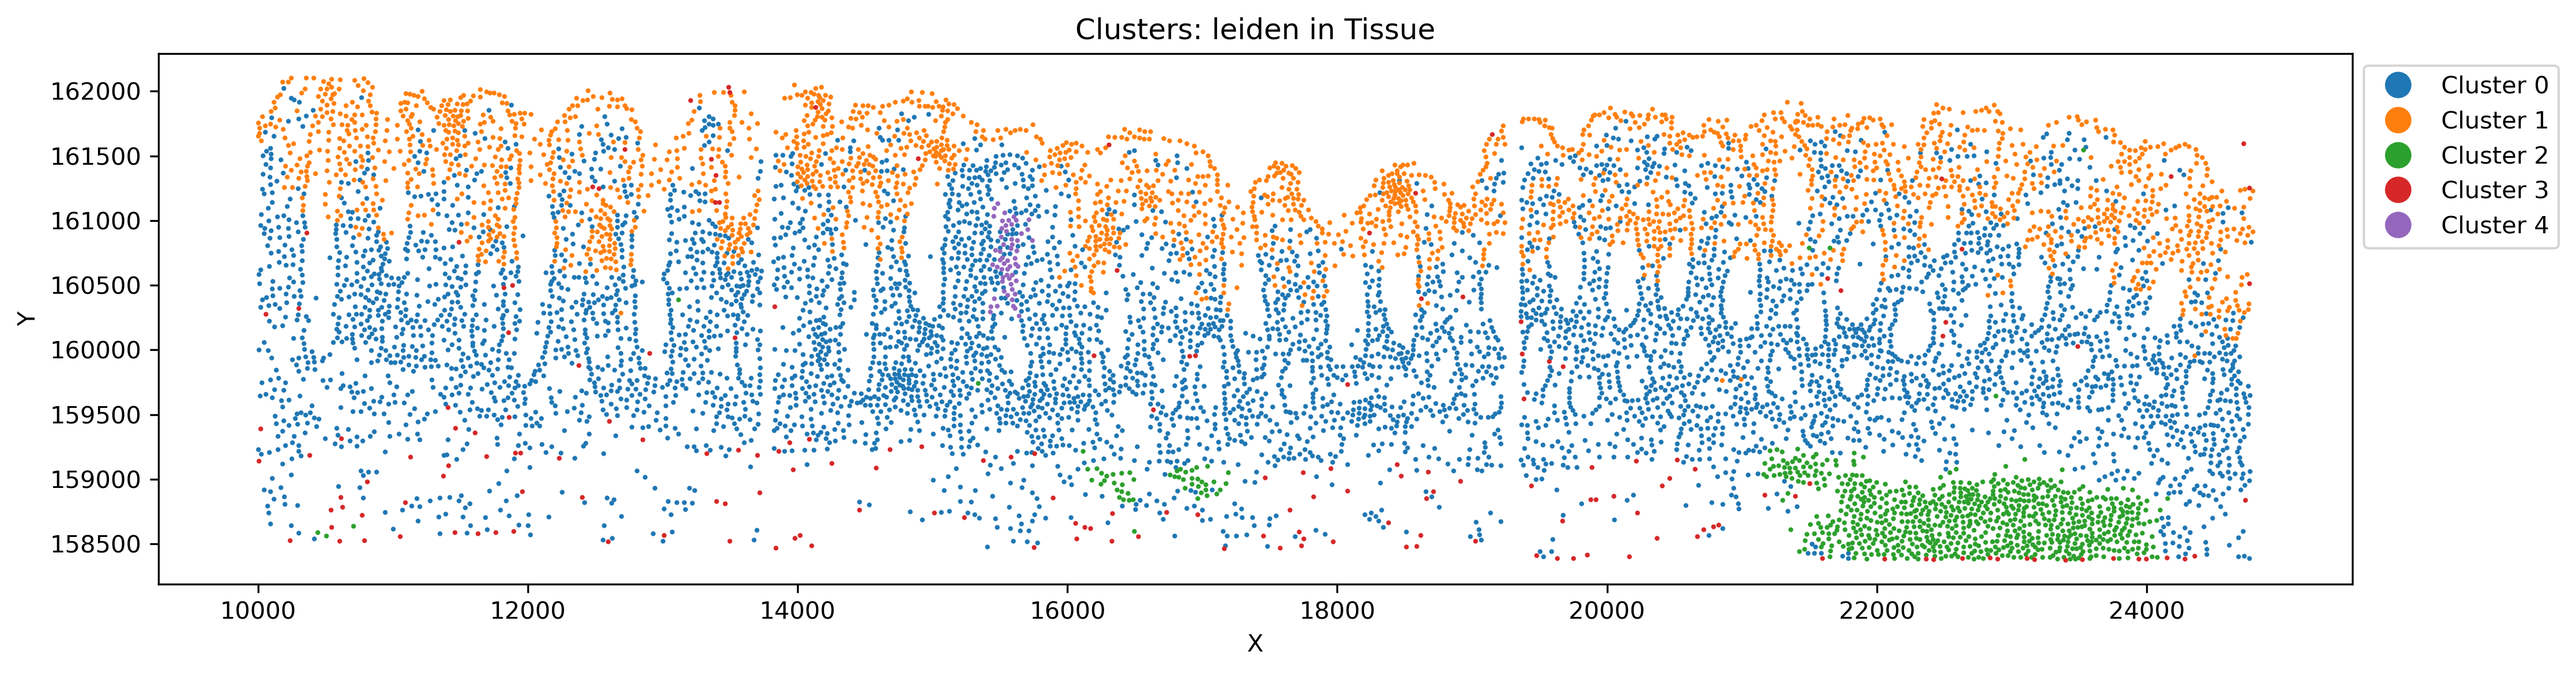

In [21]:
sc.pl.umap(embedding_adata, color = ["subset", "sample_source"])
plot_tissue(embedding_adata, "leiden", tabTen=True, figure_size=(15, 4))

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/home/jupyter/data/PlastiNet_v2/plastinet/analysis/pseudotime.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gat_epi.obs['starting_score'] = exp_epi.obs['starting_score']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


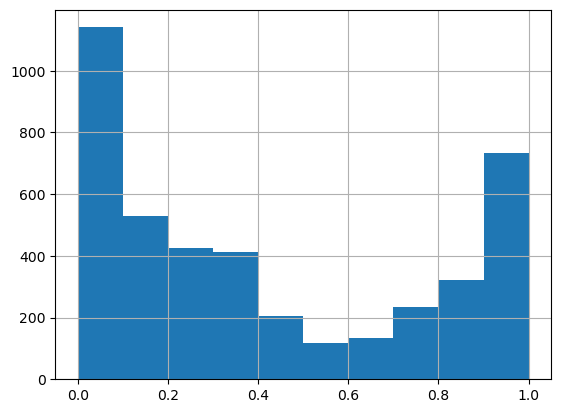

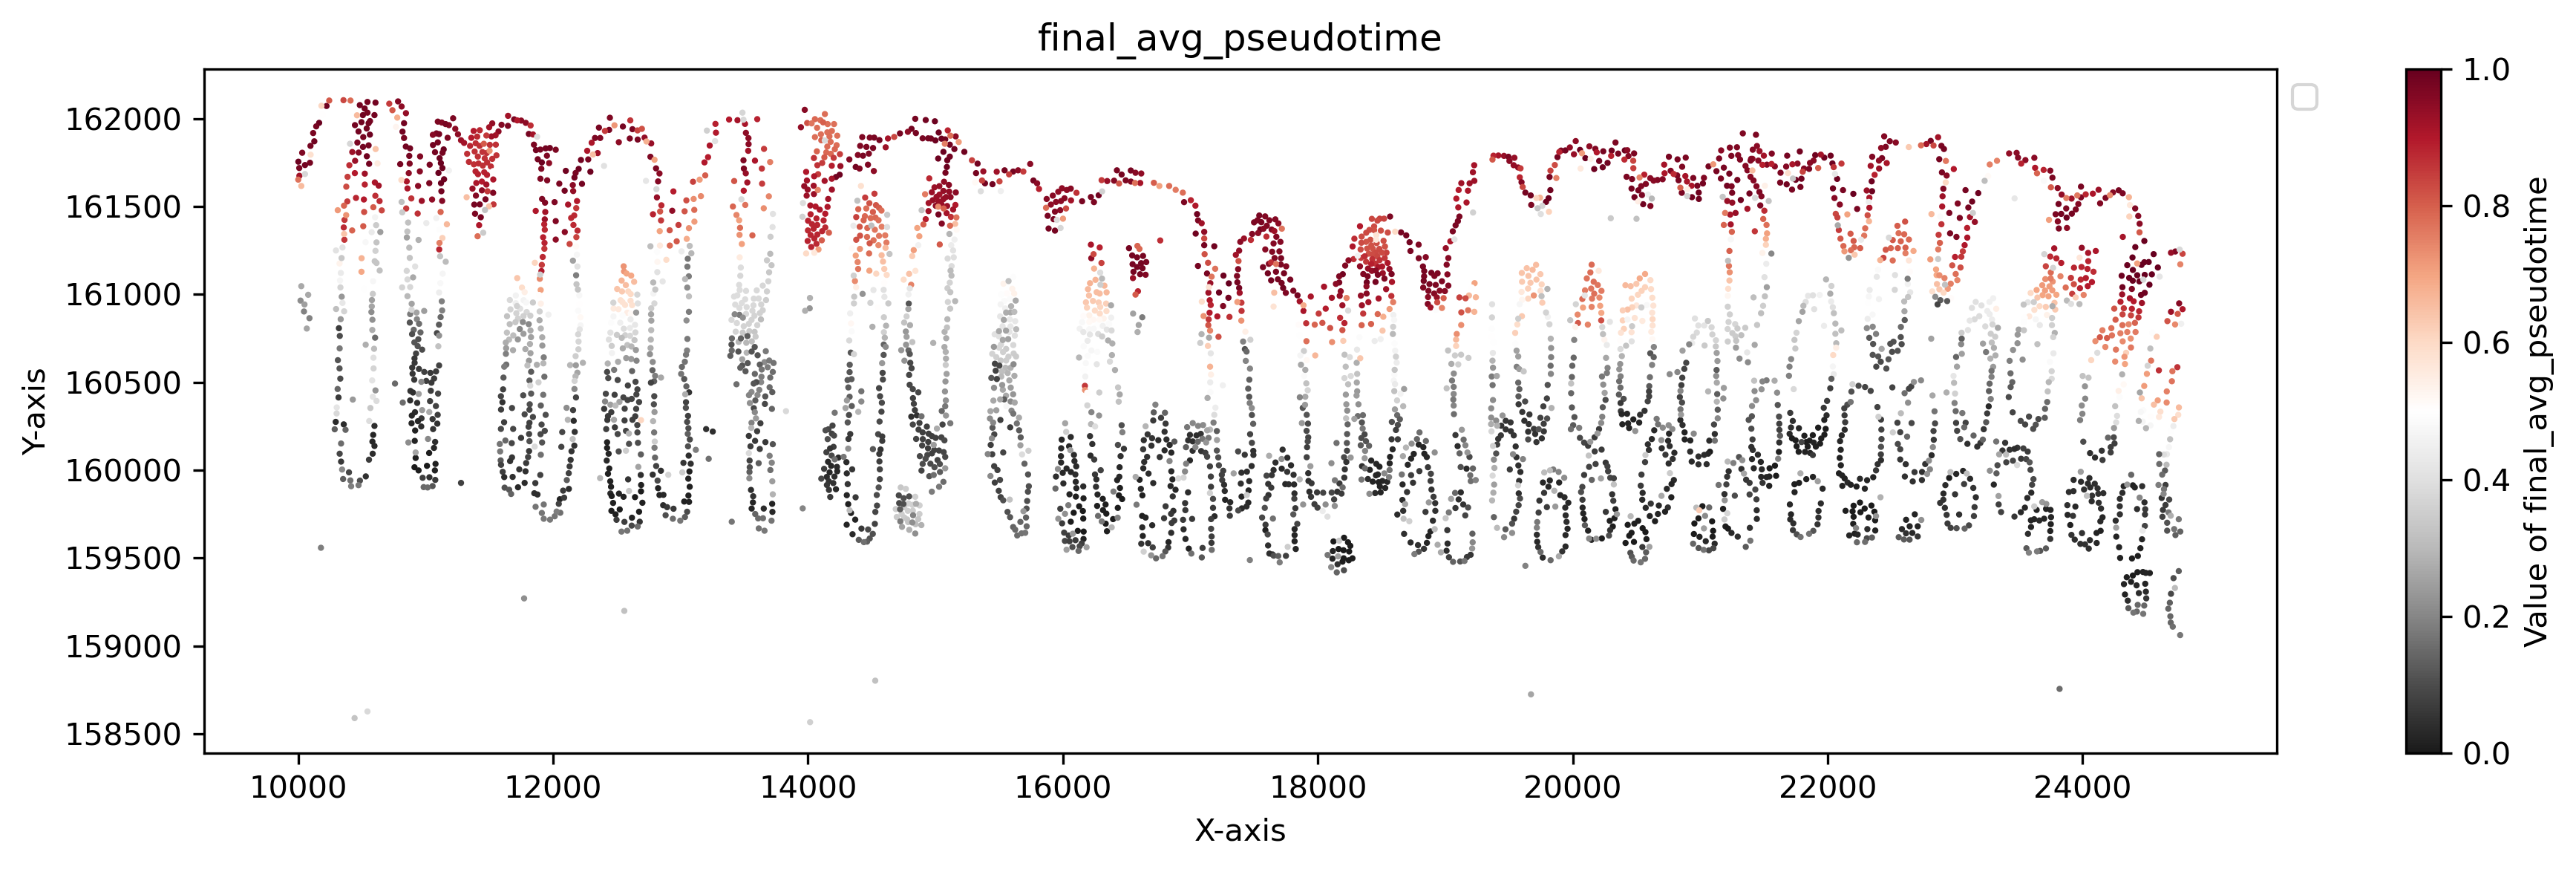

In [9]:
from plastinet.analysis import pseudotime
importlib.reload(pseudotime)

stem_cell_gene_list = ["CD44", "EPHB2", "EPHB3", "SOX9", 'ITGA1', 'ITGB1', 'ITGB2', 'ITGAX', 'ITGB4']
pseudotime.construct_differentiation_path(
    embedding_adata, 
    plastinet.adata, 
    "subset", 
    "epi", 
    stem_cell_gene_list, # starting point gene list
    None,                # ending point gene list
    N=5                 # number of starting cells 
)

plot_continous_obs(embedding_adata, "final_avg_pseudotime", size = 1, figure_size=(15, 4))

In [10]:
adata.obs["final_avg_pseudotime"] = embedding_adata.obs["final_avg_pseudotime"]

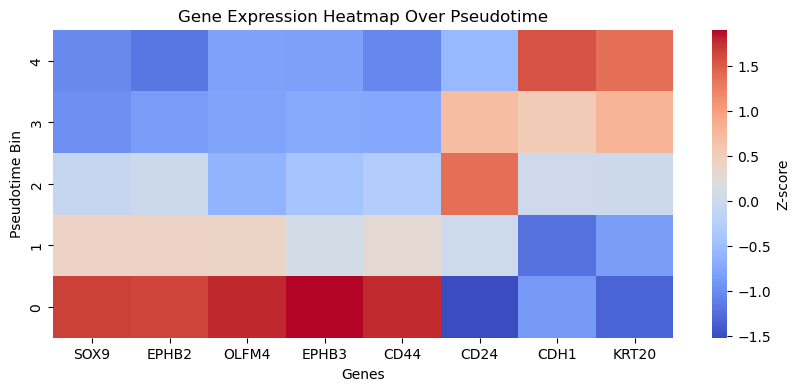

In [11]:
from plastinet.analysis import expression_analysis
importlib.reload(expression_analysis)

validation_genes = ["SOX9", "EPHB2","OLFM4", "EPHB3","CD44", "CD24", "CDH1", "KRT20"]

adata.obs["pseudotime_bins"] = expression_analysis.plot_pseudotime_heatmap(adata, validation_genes, n_bins=5)

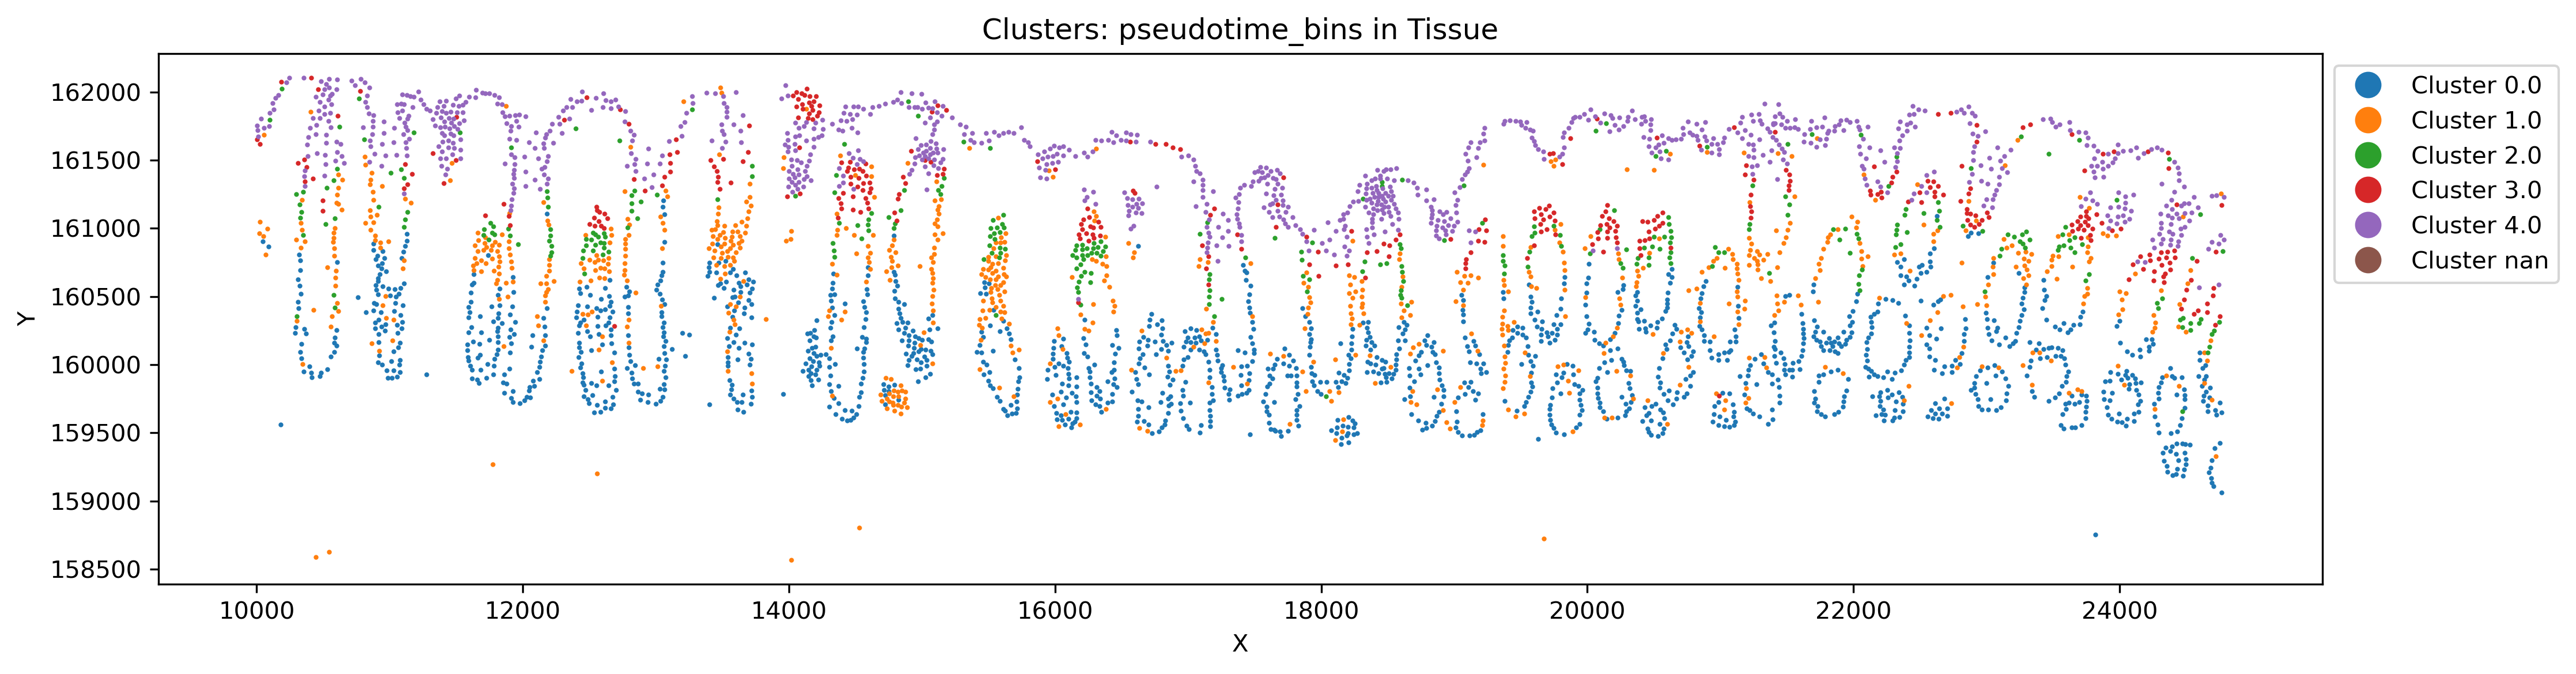

In [12]:
plot_tissue(adata, "pseudotime_bins", tabTen=True, figure_size=(15, 4))

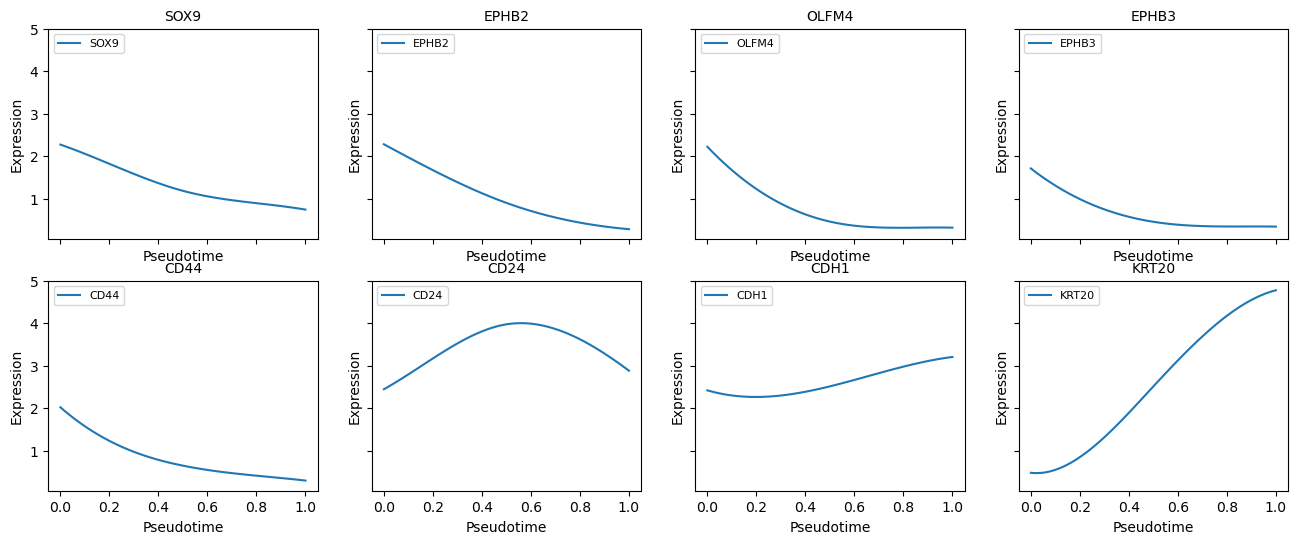

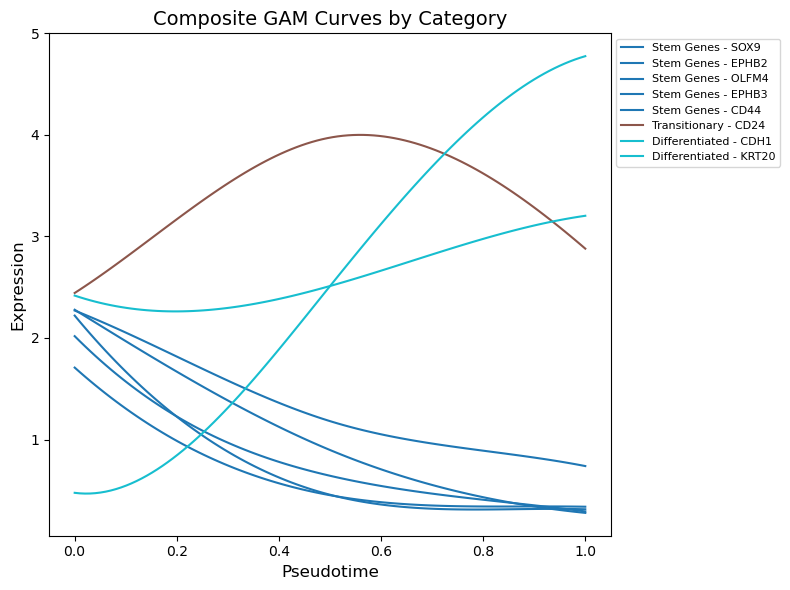

In [13]:
importlib.reload(expression_analysis)


validation_genes = {"Stem Genes" : ["SOX9", "EPHB2","OLFM4", "EPHB3", "CD44"], 
                    "Transitionary":["CD24"], 
                    "Differentiated": ["CDH1", "KRT20"]} 


expression_analysis.plot_gam_curves(adata, validation_genes)

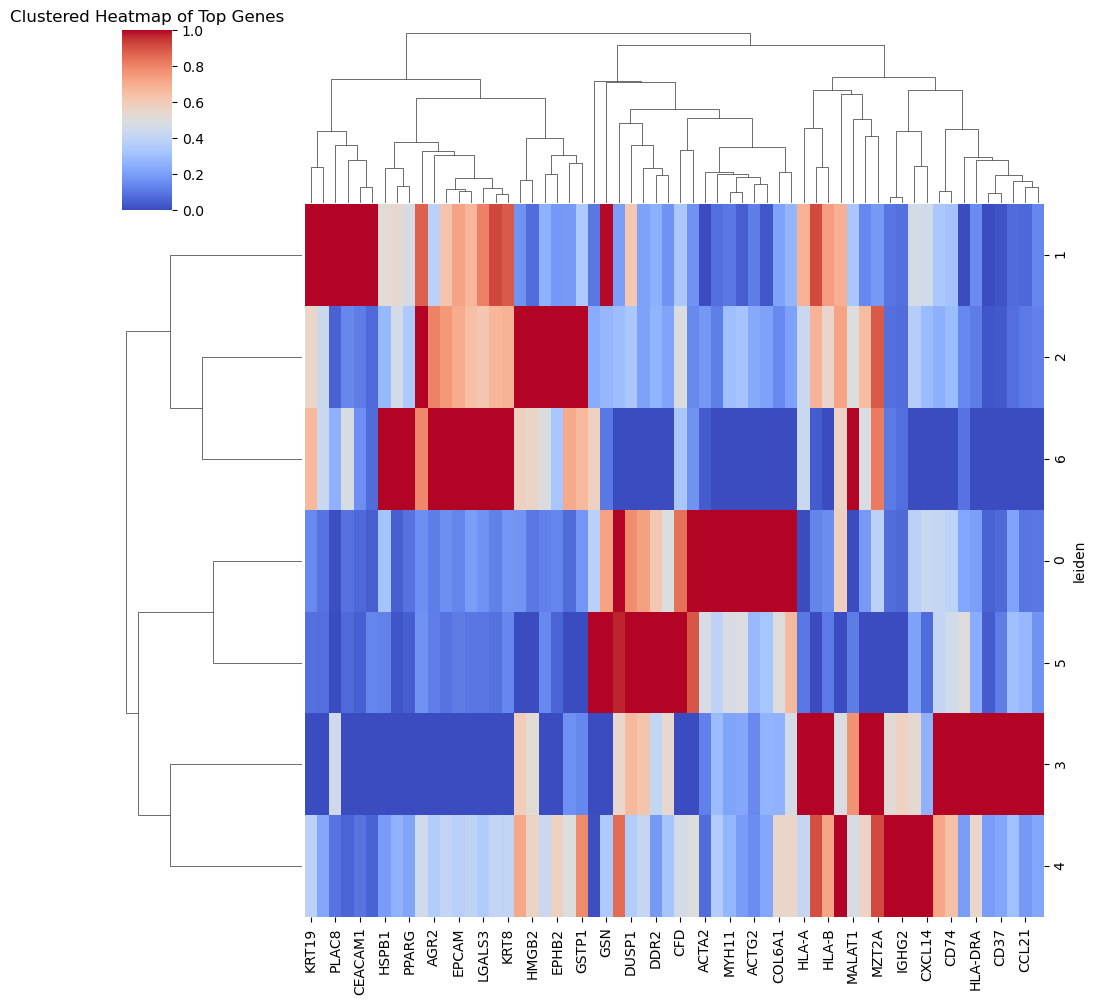

In [15]:
importlib.reload(expression_analysis)

adata.obs["leiden"] = embedding_adata.obs["leiden"]

expression_analysis.plot_top_genes_leiden(adata)

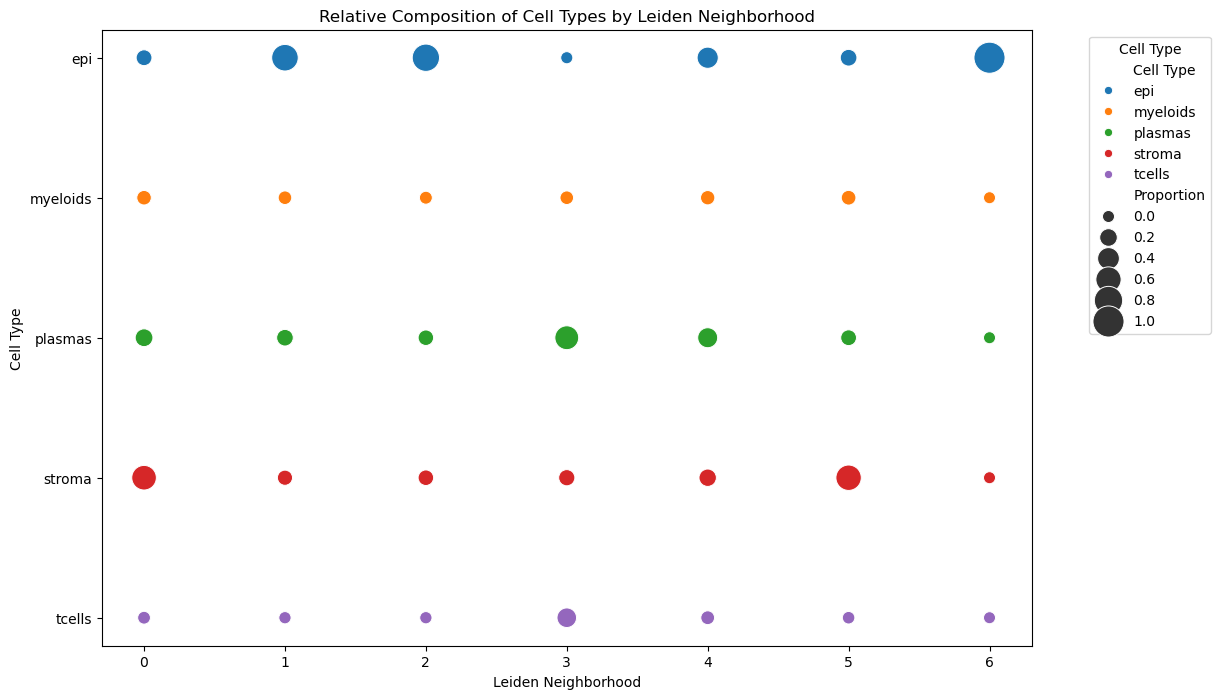

In [16]:
importlib.reload(expression_analysis)

expression_analysis.plot_composition_dotplot(adata, celltype_col='subset')

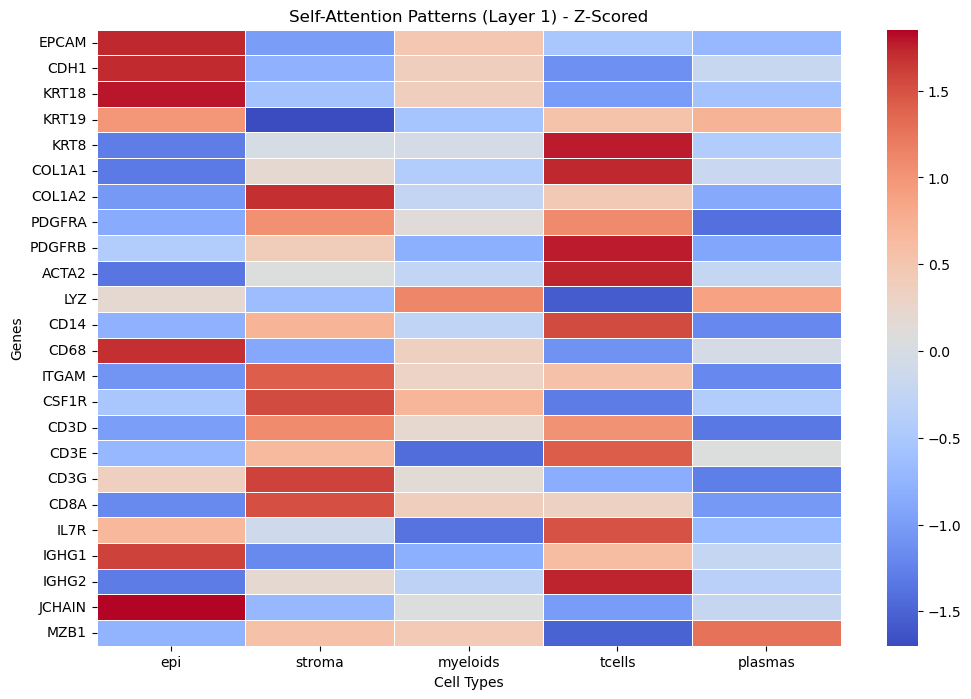

epi    stroma  myeloids    tcells   plasmas
EPCAM   1.734953 -1.003601  0.479667 -0.507142 -0.703883
CDH1    1.717290 -0.784144  0.377936 -1.121228 -0.189853
KRT18   1.784315 -0.575976  0.373927 -1.006617 -0.575649
KRT19   0.989295 -1.698312 -0.560331  0.541291  0.728056
KRT8   -1.290009 -0.018615 -0.044292  1.776090 -0.423169
COL1A1 -1.311489  0.191997 -0.433806  1.738049 -0.184753
COL1A2 -1.046270  1.697307 -0.239170  0.458312 -0.870180
PDGFRA -0.855094  1.036819  0.119894  1.100970 -1.402608
PDGFRB -0.426272  0.383526 -0.819905  1.777965 -0.915313
ACTA2  -1.355129  0.074192 -0.246726  1.746270 -0.218607
LYZ     0.198203 -0.648316  1.129307 -1.571349  0.892150
CD14   -0.780128  0.707353 -0.274665  1.543982 -1.196550
CD68    1.691416 -0.888388  0.344462 -1.108936 -0.038562
ITGAM  -1.086279  1.417034  0.303930  0.553933 -1.188611
CSF1R  -0.508062  1.544161  0.693418 -1.301218 -0.428299
CD3D   -0.991086  1.083682  0.212155  1.020644 -1.325390
CD3E   -0.710056  0.642444 -1.431915  1.423713  0.075814
CD3G    0.359186  1.591265  0.157144 -0.837969 -1.269635
CD8A   -1.178383  1.509711  0.374163  0.334033 -1.039524
IL7R    0.663147 -0.115438 -1.366652  1.492024 -0.673080
IGHG1   1.592279 -1.175905 -0.805926  0.616973 -0.227423
IGHG2  -1.301165  0.195734 -0.300825  1.749403 -0.343150
JCHAIN  1.851626 -0.710024  0.074472 -1.009524 -0.206549
MZB1   -0.769020  0.558454  0.444223 -1.508238  1.274606

In [17]:
from plastinet.analysis import attention_analysis
importlib.reload(attention_analysis)


marker_genes = ["EPCAM", "CDH1", "KRT18", "KRT19", "KRT8",
               "COL1A1", "COL1A2", "PDGFRA", "PDGFRB", "ACTA2",
                "LYZ", "CD14", "CD68", "ITGAM", "CSF1R",
                "CD3D", "CD3E", "CD3G", "CD8A", "IL7R", 
                "IGHG1", "IGHG2", "JCHAIN", "MZB1"]

attention_analysis.analyze_self_attention_layer1(embedding_adata, adata, gene_list = marker_genes, normalize=True)